In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

## Preprocessing the images

In [2]:
image_size = 224       #resize all images to 224*224

labels = ['Positive', 'Negative']          #labels from the folders

In [3]:
def create_training_data(data_dir):              #creating the training data
    
    images = []
    
    for label in labels:
        dir = os.path.join(data_dir,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):    #going through all the images in different folders and resizing them
            
            image_read = cv.imread(os.path.join(dir,image),cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read,(image_size,image_size))
            images.append([image_resized,class_num])
            
    return np.array(images)

In [4]:
train = create_training_data('/kaggle/input/surface-crack/train')
test = create_training_data('/kaggle/input/surface-crack/test')
valid = create_training_data('/kaggle/input/surface-crack/valid')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [5]:
train.shape

(600, 2)

In [6]:
test.shape

(200, 2)

In [7]:
valid.shape

(200, 2)

## Visualizing some images

Positive


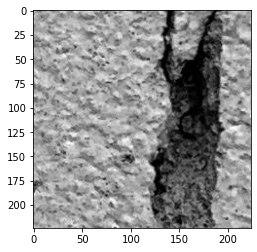

In [8]:
plt.imshow(train[1][0], cmap='gray')
print(labels[train[1][1]])

Negative


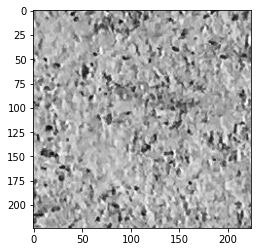

In [9]:
plt.imshow(train[500][0], cmap='gray')
print(labels[train[500][1]])

## Loading the train and valid Images and Labels together

In [10]:
X = []
y = []

for feature, label in train:
    X.append(feature)          #appending all images
    y.append(label)            #appending all labels
X_valid = []
y_valid = []
for feature, label in valid:
    X_valid.append(feature)
    y_valid.append(label)

In [11]:
X_train = np.array(X).reshape(-1, image_size, image_size, 1)
y_train = np.array(y)
y_train = np.expand_dims(y_train, axis =1)

In [12]:
X_vald = np.array(X_valid).reshape(-1, image_size, image_size, 1)
y_vald = np.array(y_valid)
y_vald = np.expand_dims(y_vald, axis =1)

## Loading the test Images and Labels together

In [13]:
X_new = []
y_new = []

for feature, label in test:
    X_new.append(feature)          #appending all images
    y_new.append(label)            #appending all labels

## Reshaping dimensions before feeding them to the neural network

In [14]:
X_test = np.array(X_new).reshape(-1, image_size, image_size, 1)
y_test = np.array(y_new)
y_test = np.expand_dims(y_test, axis =1)

In [15]:
X_train.shape

(600, 224, 224, 1)

In [16]:
y_train.shape

(600, 1)

In [17]:
X_train = X_train / 255            # normalizing
X_test = X_test / 255
X_vald = X_vald/ 255

# Creating the CNN Model:

In [18]:
i = Input(X_train.shape[1:])                                        # Input Layer

a = Conv2D(32, (3,3), activation ='relu', padding = 'same')(i)      # Convolution
a = BatchNormalization()(a)                                         # Batch Normalization
a = Conv2D(32, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)                                            # Max Pooling

a = Conv2D(64, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(64, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Conv2D(128, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(128, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Conv2D(256, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(256, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Flatten()(a)                                                      # Flatten
a = Dense(512, activation = 'relu')(a)                               # Fully Connected layer
a = Dropout(0.4)(a)
a = Dense(512, activation = 'relu')(a)
a = Dropout(0.3)(a)
a = Dense(512, activation = 'relu')(a)
a = Dropout(0.1)(a)

a = Dense(1, activation = 'sigmoid')(a)                               # Output Layer

model = Model(i,a)

2023-01-09 16:22:16.891057: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Compiling and viewing the model summary

In [19]:
model.compile(optimizer=Adam(lr = 0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Data Augmentation

In [20]:
batch_size = 4

train_gen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1.,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   cval=0)

train_generator = train_gen.flow(X_train,y_train,batch_size)
steps_per_epoch = X_train.shape[0]//batch_size

In [21]:
checkpoint = ModelCheckpoint('surface-crack', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [22]:
r = model.fit(train_generator, validation_data=(X_vald, y_vald), steps_per_epoch = steps_per_epoch, epochs= 15,
                       callbacks = [checkpoint])

2023-01-09 16:22:17.757736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
150/150 [==============================] - 130s 855ms/step - loss: 2.0583 - accuracy: 0.5500 - val_loss: 1.5247 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.52470, saving model to surface-crack


2023-01-09 16:24:30.152192: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/15
150/150 [==============================] - 128s 852ms/step - loss: 1.4697 - accuracy: 0.6067 - val_loss: 3.7309 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 1.52470
Epoch 3/15
150/150 [==============================] - 131s 874ms/step - loss: 1.5664 - accuracy: 0.6800 - val_loss: 2.0195 - val_accuracy: 0.6250

Epoch 00003: val_loss did not improve from 1.52470
Epoch 4/15
150/150 [==============================] - 130s 864ms/step - loss: 1.0895 - accuracy: 0.7283 - val_loss: 0.1218 - val_accuracy: 0.9500

Epoch 00004: val_loss improved from 1.52470 to 0.12180, saving model to surface-crack
Epoch 5/15
150/150 [==============================] - 129s 857ms/step - loss: 0.7261 - accuracy: 0.7767 - val_loss: 0.1128 - val_accuracy: 0.9750

Epoch 00005: val_loss improved from 0.12180 to 0.11282, saving model to surface-crack
Epoch 6/15
150/150 [==============================] - 127s 844ms/step - loss: 0.8129 - accuracy: 0.7900 - val_loss: 0.0341 - val_accuracy:

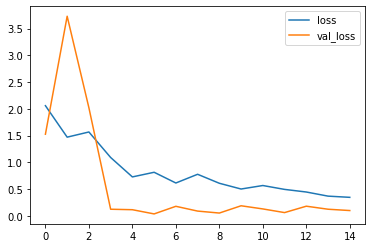

In [23]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [24]:
new_model = tf.keras.models.load_model('surface-crack')   #loading model to train further

In [25]:
new_model.compile(optimizer = Adam(lr = 0.00001), loss = 'binary_crossentropy', metrics = ['accuracy']) 

checkpoint1 = ModelCheckpoint('surface-crack', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

batch_size = 4

r1 = new_model.fit(train_generator, validation_data=(X_vald, y_vald), steps_per_epoch = steps_per_epoch, epochs= 10,
                       callbacks = [checkpoint1])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
150/150 [==============================] - 131s 865ms/step - loss: 0.5133 - accuracy: 0.8367 - val_loss: 0.0721 - val_accuracy: 0.9750

Epoch 00001: val_loss improved from inf to 0.07206, saving model to surface-crack
Epoch 2/10
150/150 [==============================] - 136s 906ms/step - loss: 0.4315 - accuracy: 0.8600 - val_loss: 0.0475 - val_accuracy: 0.9900

Epoch 00002: val_loss improved from 0.07206 to 0.04746, saving model to surface-crack
Epoch 3/10
150/150 [==============================] - 147s 983ms/step - loss: 0.4332 - accuracy: 0.8783 - val_loss: 0.1816 - val_accuracy: 0.9350

Epoch 00003: val_loss did not improve from 0.04746
Epoch 4/10
150/150 [==============================] - 138s 922ms/step - loss: 0.4332 - accuracy: 0.8600 - val_loss: 0.0451 - val_accuracy: 0.9900

Epoch 00004: val_loss improved from 0.04746 to 0.04505, saving model to surface-crack
Epoch 5/10
150/150 [==============================] - 136s 906ms/step - loss: 0.3957 - accuracy: 0.8650 - v

In [26]:
final_model = tf.keras.models.load_model('surface-crack')

In [27]:
pred = final_model.predict(X_test, batch_size = 8)
pred

array([[4.62979674e-02],
       [1.30086839e-02],
       [9.75982308e-01],
       [4.23389673e-02],
       [1.70373917e-03],
       [1.48514986e-01],
       [9.78462458e-01],
       [2.44391561e-02],
       [2.65438348e-01],
       [9.56040382e-01],
       [1.54949546e-01],
       [9.76542890e-01],
       [9.68182802e-01],
       [8.00728202e-01],
       [2.25197196e-01],
       [6.30965829e-02],
       [8.71459007e-01],
       [5.68544865e-02],
       [9.87412095e-01],
       [9.92628932e-01],
       [9.90036070e-01],
       [9.87524211e-01],
       [9.89127278e-01],
       [9.31166887e-01],
       [9.97092724e-01],
       [9.83677745e-01],
       [1.48433745e-02],
       [9.80013192e-01],
       [7.19070435e-04],
       [5.80707192e-03],
       [8.88201594e-01],
       [1.04485864e-09],
       [1.66743994e-04],
       [7.18718290e-01],
       [1.39561296e-03],
       [2.22415924e-02],
       [1.23499364e-01],
       [8.72850418e-03],
       [5.86810708e-03],
       [3.64975154e-01],


In [28]:
pred_final = np.where(pred>0.5,1,0)
pred_final

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
    

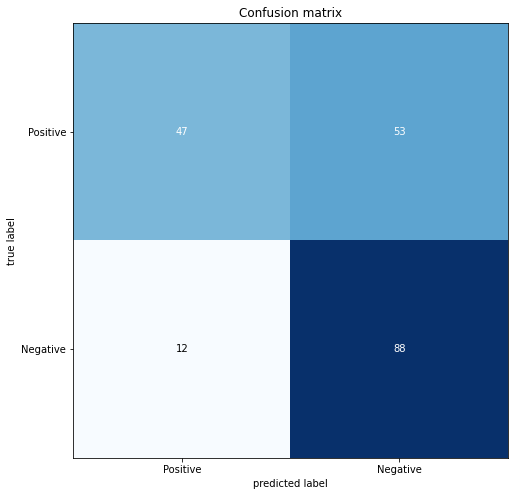

In [29]:
# Get the confusion matrix
CM = confusion_matrix(y_test, pred_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Positive','Negative'], fontsize=10)
plt.yticks(range(2), ['Positive','Negative'], fontsize=10)
plt.show()

In [30]:
def perf_measure(y_test, pred_final):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(pred_final)): 
        if y_test[i]==pred_final[i]==1:
           TP += 1
        if y_test[i]==1 and y_test[i]!=pred_final[i]:
           FP += 1
        if y_test[i]==pred_final[i]==0:
           TN += 1
        if y_test[i]==0 and y_test[i]!=pred_final[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [31]:
tp, fp, tn ,fn = perf_measure(y_test,pred_final)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.62
Precision of the model is 0.88
F-Score is 0.73
